In [1]:
from __future__ import print_function
import time
import numpy as np
import argparse
import torch

import warnings ; warnings.filterwarnings('ignore') # mute warnings, live dangerously

# import matplotlib.pyplot as plt
# import matplotlib as mpl ; mpl.use("Agg")

from model import IQN
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import HTML

import torchtext
from utils import tokenizer_with_preprocessing
import os
from torchtext.vocab import Vectors
from trainer import Trainer
NEWS_PATH = os.path.join('..', 'data', 'news')

In [2]:
parser = argparse.ArgumentParser(description=None)
parser.add_argument('-e', '--env', default='PongNoFrameskip-v4', type=str, help='gym environment')
parser.add_argument('-d', '--density', default=1, type=int, help='density of grid of gaussian blurs')
parser.add_argument('-r', '--radius', default=5, type=int, help='radius of gaussian blur')
parser.add_argument('-f', '--num_frames', default=100, type=int, help='number of frames in movie')
parser.add_argument('-i', '--first_frame', default=150, type=int, help='index of first frame')
parser.add_argument('-dpi', '--resolution', default=75, type=int, help='resolution (dpi)')
parser.add_argument('-s', '--save_dir', default='./movies/', type=str,
                    help='dir to save agent logs and checkpoints')
parser.add_argument('-p', '--prefix', default='default', type=str, help='prefix to help make video name unique')
parser.add_argument('-c', '--checkpoint', default='*.tar', type=str,
                    help='checkpoint name (in case there is more than one')
parser.add_argument('-o', '--overfit_mode', default=False, type=bool,
                    help='analyze an overfit environment (see paper)')

# text parameter
parser.add_argument('--max_length', type=int, default=64)
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--target_update_freq', type=int, default=100)
parser.add_argument('--evaluation_freq', type=int, default=10)
parser.add_argument('--network_save_freq', type=int, default=100)
parser.add_argument('--num_actions', type=int, default=1)

parser.add_argument('--min_freq', type=int, default=10)
parser.add_argument('--embedding_dim', type=int, default=300)
parser.add_argument('--n_filters', type=int, default=50)
parser.add_argument('--filter_sizes', type=list, default=[3, 4, 5])
parser.add_argument('--pad_idx', type=list, default=1)
parser.add_argument('--gamma', type=float, default=0.0)
parser.add_argument('--learning_rate', type=float, default=2.5e-5)
parser.add_argument('--num_quantile', type=int, default=64)
parser.add_argument('--round', type=float, default=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
parser.add_argument('--device', type=str, default=device)

args = parser.parse_args(args=[])

args.rnn = True

# データを取り出す

In [3]:
# 読み込んだ内容に対して行う処理を定義
TEXT = torchtext.data.Field(sequential=True, tokenize=tokenizer_with_preprocessing,
                            use_vocab=True, lower=True, include_lengths=True,
                            batch_first=True, fix_length=args.max_length,
                            init_token="<cls>", eos_token="<eos>")
LABEL = torchtext.data.Field(sequential=False, use_vocab=False, dtype=torch.float)

train_ds = torchtext.data.TabularDataset.splits(
    path=NEWS_PATH, train='text_train.tsv',
    format='tsv',
    fields=[('Text1', TEXT), ('Text2', TEXT), ('Label', LABEL)])
train_ds = train_ds[0]

test_ds = torchtext.data.TabularDataset.splits(
    path=NEWS_PATH, train='text_test.tsv',
    format='tsv',
    fields=[('Text1', TEXT), ('Text2', TEXT), ('Label', LABEL)])
test_ds = test_ds[0]

japanese_fasttext_vectors = Vectors(name='../data/news/cc.ja.300.vec')
TEXT.build_vocab(train_ds,
                 vectors=japanese_fasttext_vectors,
                 min_freq=args.min_freq)
TEXT.vocab.freqs

train_dl = torchtext.data.Iterator(
    train_ds, batch_size=1, train=True)
test_dl = torchtext.data.Iterator(
    test_ds, batch_size=1, train=True, shuffle=False)

# モデルの作成

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

vocab_size = len(TEXT.vocab.freqs)
model = IQN(TEXT.vocab.vectors, vocab_size, args.embedding_dim, args.n_filters,
                         args.filter_sizes, args.pad_idx,
                         d_model=300,
                         n_actions=args.num_actions,
                         n_quant=args.num_quantile,
                         rnn=args.rnn)

model = model.to(device)

trainer = Trainer(args, TEXT, train_dl)
trainer.load_model()
trainer.model.eval()

IQN(
  (embedding): Embedding(2638, 300)
  (phi): Linear(in_features=64, out_features=64, bias=True)
  (cnn): CNN(
    (convs): ModuleList(
      (0): Conv2d(1, 50, kernel_size=(3, 300), stride=(1, 1))
      (1): Conv2d(1, 50, kernel_size=(4, 300), stride=(1, 1))
      (2): Conv2d(1, 50, kernel_size=(5, 300), stride=(1, 1))
    )
    (fc0): Linear(in_features=150, out_features=64, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (rnn): RNN(
    (lstm): LSTM(300, 50, batch_first=True, bidirectional=True)
    (attn): Attn(
      (fc): Sequential(
        (0): Linear(in_features=50, out_features=24, bias=True)
        (1): ReLU(inplace=True)
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=24, out_features=1, bias=True)
      )
    )
    (fc0): Linear(in_features=50, out_features=64, bias=True)
  )
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc_q): Linear(in_features=64, o

# rolloutの作成

In [26]:
# HTMLを作成する関数を実装
def highlight(word, attn):
    "Attentionの値が大きいと文字の背景が濃い赤になるhtmlを出力させる関数"

    if attn >= 0:
        html_color = '#%02X%02X%02X' % (
            255, int(255*(1 - attn)), int(255*(1 - attn)))
    else:
        html_color = '#%02X%02X%02X' % (
            int(255*(1 - attn)), 255, int(255*(1 - attn)))
    return '<span style="background-color: {}"> {}</span>'.format(html_color, word)

def mk_html(sentence, attens):

    # 表示用のHTMLを作成する
#     html = '正解ラベル：{}<br>推論ラベル：{}<br><br>'.format(reward, pred)
    html = ""
    # 1段目のAttention
    html += '[TransformerBlockの1段目のAttentionを可視化]<br>'
    for word, attn in zip(sentence, attens):
        word = TEXT.vocab.itos[word]
        if word[0] == '<':
            word = word[1:-1]
            if (word == 'pad') or (word=='unk'):
                continue
        html += highlight(word, attn)
    html += "<br><br>"

    return html

def blur_func(I, mask):
    return I * mask #+ I * mask#+ gaussian_filter(I, sigma=3) * mask

In [32]:
eta = 0.1
std_list = []
for batch in train_dl:
    with torch.no_grad():
        state = batch.Text1[0].to(device)
        curr_q, _, _ = trainer.model(state, eta, True)
    std = curr_q.view(-1).std().cpu().detach().item()
    std_list.append(std)
    if std > 4:
        state = state.view(-1).cpu().numpy()
        for word in state:
            vocab = TEXT.vocab.itos[word]
            if (vocab == '<pad>') or (vocab == '<unk>'):
                continue
            print(vocab+' ', end='')
        print()

<cls> <company> 0月期 連結 最終 益 0億 円 前年同期 0億 円 <span> <company> 営業利益 00 増 0億 円 0月期 <span> <company> 純利益 00 増 最高 0月 0億 円 海外 値上げ 効果 <span> <company> 続伸 0月期 最高 益 0月期 期待 声 <eos> 
<cls> <company> 0年0月期 営業 増益 00 超 報道 <organization> ｺﾝｾﾝｻｽ 00 下回る <span> <company> 反発 し 始まる 来期 00 超 営業 増益 見通し <span> <company> 反発 ｽﾏﾎ 販売増 来期 増益 報道 好感 <eos> 
<cls> <company> 0 第 0回 社債 発行 <span> <company> 第 0回 債 a 格付け jcr <span> ｽﾌﾟﾘﾝﾄ 小動き <company> 買収 延期 報道 <span> <company> 堅調 ｽﾌﾟﾘﾝﾄ 買収 延期 報道 反応 薄 <eos> 
<cls> <company> 発行 体格 付 aa 安定的 維持 <span> <company> 経常 益 00 増 0億 円 0年0月期 <location> 塩ビ 子会社 好調 <span> <company> 朝安 後 下げ渋る 前期 経常 益 00 増 下支え <eos> 
<cls> <organization> 定額 放題 正式発表 月額 0円 0月 開始 <span> 日本ibm 企業 向け クラウド サービス 機能 強化 <span> 日本ibm 統合 基盤 クラウド サービス 提供 <span> <company> <location> <organization> 0割 増 円安 ﾃﾚﾋﾞ 輸出 拡大 ｱｼﾞｱ <organization> <span> <company> 00 超 上昇 円安 日本株 感 主力株 買い <eos> 
<cls> <organization> 下げ 転じる 赤字 幅 拡大 一段 高 <eos> 
<cls> <company> 後場 一 段 高 年初来高値 更新 構造改革 進む 期待 <eos> 
<cls> 決算 星取表 <company> 据え置き ● ｻﾌﾟﾗｲｽﾞﾚｼｵ

<cls> 決算 星取表 <company> 据え置き ● ｻﾌﾟﾗｲｽﾞﾚｼｵ n 0年0月期 <span> <company> 0月期 連結 最終 益 0億 円 <span> <company> 0月期 純利益 00 増 株式 黒字転換 <span> <company> 最終 益 00 増 0年0月期 0億 円 <span> <organization> <person> 会長 辞任 後任 <person> 前 <organization> 長 <eos> 
<cls> 東証 0部 売買 0年 半 ぶり 高値 値 株 商い 活発 <eos> 
<cls> ネット 新 iot 0兆 円 インフラ つなぐ <span> <organization> 0日 ぶり 反落 アリババ 成長 鈍化 警戒感 <span> <company> 続落 アリババ 成長 鈍化 <span> <company> 続落 アリババ 成長 鈍化 懸念 <eos> 
<cls> 破綻 企業 <company> 銀 行員 ら 処分 検討 <span> <company> 銀 使い 海外 米 社 開発 <span> 気 なる 話題 0 バーナンキ <location> <person> 人工知能 <span> <company> 小高い <location> 社 提携 報道 <eos> 
<cls> <company> 0月期 連結 最終 益 0億 円 <span> <company> 者 <person> 会長 退任 <span> <company> 純利益 00 増 センサー 伸びる 0月 <eos> 
<cls> <organization> 今期 営業 益 00 増 最高 益 更新 インフラ 設備 好調 <span> <organization> 副社長 <location> 鉄道車両 0 強 合併 影響 ない <span> <organization> 副社長 円安 効果 売上高 0億 円 営業 益 0億 <person> <span> <organization> 会長 顧客 一体 <location> <location> <location> 連携 表明 <span> <organization> 管理 効率化 ソフト <eos> 
<cls> <company> 信託 海外 融資 

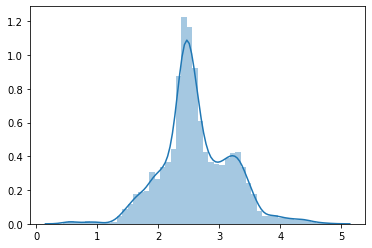

In [36]:
sns.distplot(std_list)

In [37]:
std_list = []
for i, batch in enumerate(test_dl):
    with torch.no_grad():
        state = batch.Text1[0].to(device)
        curr_q, _, _ = trainer.model(state, eta, True)
    std = curr_q.view(-1).std().cpu().detach().item()
    std_list.append(std)
    if std > 4:
        print('i = ', i)
        state = state.view(-1).cpu().numpy()
        for word in state:
            vocab = TEXT.vocab.itos[word]
            if (vocab == '<pad>') or (vocab == '<unk>'):
                continue
            print(vocab+' ', end='')
        print()

i =  31
<cls> <company> <location> たばこ 大手 資産 取得 約 0億 円 <span> <company> 海外 ma 国 比 たばこ 大手 買収 発表 <span> <company> 小高い 比 たばこ 大手 買収 0億 円 <eos> 
i =  54
<cls> 決算 星取表 <company> ● ｻﾌﾟﾗｲｽﾞﾚｼｵ n 0年0月期 <span> <company> 前期 連結 最終 益 0億 円 前々 期 0億 円 黒字 <span> <company> 0年0月期 純利益 00 減 国内 たばこ ず <span> <company> 安い 今期 純利益 予想 <span> <company> 益 見通し 失望 生産 課題 <eos> 
i =  145
<cls> 決算 星取表 0 i 0 hd ● ｻﾌﾟﾗｲｽﾞﾚｼｵ n 0年0月期 <span> <company> 前期 連結 最終 益 0億 円 前々 期 0億 円 黒字 <span> <company> 0年0月期 純利益 00 増 予想 <span> <company> <location> コンビニ 事業 取得 0億 円 <span> <company> <location> コンビニ 約 0億 円 取得 <span> <company> 米 0万 店 布石 <person> 前 会長 退任 0年 大型 買収 <span> <eos> 
i =  364
<cls> 決算 星取表 <company> 据え置き ● ｻﾌﾟﾗｲｽﾞﾚｼｵ n 0年0月期 <span> <company> 0月期 連結 最終 益 0億 円 前年同期 0億 円 黒字 <span> <company> 0月期 純利益 00 増 紙おむつ 好調 <span> <company> 社長 資金 成長 投資 <eos> 
i =  571
<cls> 決算 星取表 <company> ● ｻﾌﾟﾗｲｽﾞﾚｼｵ n 0年0月期 <span> <company> 前期 連結 最終 益 0億 円 前々 期 0億 円 黒字 <span> <company> 今期 0億 円 赤字 統合 費用 <span> 気 なる 話題 0 今期 最終赤字 0億 円 <span> <company> 売り気配 今

i =  2916
<cls> 投信 基準 0日 速報 値 更新 <company> 国際 投信 <span> <company> <person> pb 証券 合併 <eos> 
i =  2919
<cls> 投信 基準 0日 速報 値 更新 <company> 国際 投信 <span> <company> 全 男性 行員 0カ月 0 メガ 銀 初 管理 <eos> 
i =  3018
<cls> 決算 星取表 <company> 据え置き ● ｻﾌﾟﾗｲｽﾞﾚｼｵ n 0年0月期 <span> <company> 0月期 連結 最終 益 0億 円 前年同期 0億 円 黒字 <span> <company> 0月期 純利益 00 増 保有 株式 売却 益 寄与 <eos> 
i =  3112
<cls> 口座 管理 共有 <company> <span> <company> 頭取 信託 社長 <person> <span> <company> <company> 頭取 <person> 常務 昇格 0月0日 付 <span> <company> 続落 0年0月期 連結純利益 00 減 <eos> 
i =  3158
<cls> 決算 星取表 <company> 据え置き ● ｻﾌﾟﾗｲｽﾞﾚｼｵ n 0年0月期 <span> <company> 0月期 連結 最終 益 0億 円 前年同期 0億 円 黒字 <span> <company> 0月期 純利益 00 減 国債 売却 益 減少 <span> <company> 次期 <organization> 完成 0年度 切り替え <span> <company> 0月 純利益 00 減 <span> 購入 者 0位 <eos> 
i =  3296
<cls> 決算 星取表 <company> 据え置き ● ｻﾌﾟﾗｲｽﾞﾚｼｵ n 0年0月期 <span> <company> 0月期 連結 最終 益 0億 円 前年同期 0億 円 黒字 <span> <company> 0月期 純利益 00 増 収入 00 増 <span> あんしん 生命 社長 <person> <person> 発表 <span> <company> 社内 全 拠点 ai 活用 対応 <eos> 
i =  3308
<cls> 決算 星

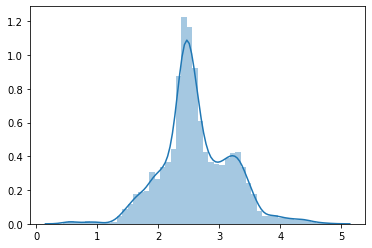

In [38]:
sns.distplot(std_list)

In [39]:
states = []
rewards = []
for batch in test_dl:
    states.append(batch.Text1[0].numpy()[0])
    rewards.append(batch.Label.numpy()[0])
states = np.array(states)
rewards = np.array(rewards)

reward:  2.59542 mean:  1.386849 median:  1.2734082 std:  4.710852 sr:  0.29439452


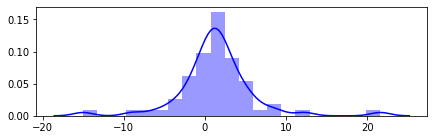

In [61]:
idx = 640
eta = 1

sentence = states[idx]
state = torch.LongTensor(sentence).to(device).unsqueeze(0)

# 1次元maskの作成
mask = np.zeros((1*args.max_length, args.max_length)).astype(np.int8)

for j in range(args.max_length):
    circle = np.ones([args.max_length])
    if (sentence[j] == 0) or (sentence[j] == 1) \
            or (sentence[j] == 2) or (sentence[j] == 3):
        circle[j] = 1
    else:
        circle[j] = 0
    mask[j] = circle.astype(np.int8)

# ネットワークの出力を得る
with torch.no_grad():
    curr_q, _, _ = trainer.model(state, eta, True)
    L = curr_q.mean()

# 各ピクセルにマスクする
masked_sentence = blur_func(sentence, mask)

# ノイズを入れたデータの出力を得る
state = torch.LongTensor(masked_sentence).to(device)
state = state.view(-1, args.max_length)
with torch.no_grad():
    masked_curr_q, _, _ = trainer.model(state, eta, True)
    l = masked_curr_q.mean(axis=1)

pad_mask = np.ones([args.max_length])
for j in range(args.max_length):
    if (sentence[j] == 0) or (sentence[j] == 1) \
            or (sentence[j] == 2) or (sentence[j] == 3):
        pad_mask[j] = 0

# スコアを記憶する配列
scores = np.zeros(args.max_length)   # saliency scores S(t,i,j)

for j in range(0, args.max_length):
    # d=5としてその部分を描画する
    scores[j] = (L-l[j]).pow(2).sum().mul_(.5).item()
#     scores[j] = (L-l[j]).sum().item()

scores = scores * pad_mask
saliency = scores / (np.abs(scores).max() + 1e-20)

# S = saliency.copy()
# pmax = S.max()

# S -= S.min()
# S = pmax * S / S.max()

fig, ax = plt.subplots(1, figsize=(7, 2));
sns.distplot(curr_q.view(-1).cpu().numpy(), color='blue', ax=ax)

print('reward: ', rewards[idx], 
          'mean: ', np.mean(curr_q.view(-1).cpu().numpy()),
          'median: ', np.median(curr_q.view(-1).cpu().numpy()),
          'std: ', np.std(curr_q.view(-1).cpu().numpy()),
          'sr: ', np.mean(curr_q.view(-1).cpu().numpy()) / np.std(curr_q.view(-1).cpu().numpy()))

html_output = mk_html(states[idx], saliency)
HTML(html_output)

In [50]:
saliency

array([0.00000000e+00, 1.40272509e-02, 1.67784263e-04, 6.28894496e-05,
       1.76614283e-04, 4.28480717e-05, 2.19071400e-04, 7.79620322e-06,
       9.33248493e-15, 1.74182693e-05, 9.33248493e-15, 9.33248493e-15,
       9.33248493e-15, 1.74002406e-04, 3.73351893e-09, 3.50679972e-04,
       1.05213319e-03, 9.33248493e-15, 4.82040382e-04, 1.01755216e-03,
       1.25114335e-03, 9.33248493e-15, 8.20235024e-04, 1.59639946e-03,
       9.33248493e-15, 9.33248493e-15, 9.33248493e-15, 9.33248493e-15,
       9.73725698e-03, 1.07324265e-02, 7.85326711e-03, 0.00000000e+00,
       0.00000000e+00, 9.33248493e-15, 9.33248493e-15, 9.33248493e-15,
       3.76836719e-03, 3.44626968e-02, 3.65198817e-02, 9.33248493e-15,
       7.38895566e-03, 9.33248493e-15, 9.33248493e-15, 9.33248493e-15,
       1.28885377e-03, 4.17542671e-03, 9.33248493e-15, 3.17097519e-05,
       5.44733413e-09, 9.33248493e-15, 9.33248493e-15, 3.00320237e-05,
       9.33248493e-15, 3.10349444e-02, 1.75753459e-01, 9.33248493e-15,
      